In [1]:
def ppard(pd):
    pd.write_JSON("foo.json")
    with open("foo.json", "r") as f:
        for l in f.readlines():
            print(l)

In [2]:
cd ..

/playpen-raid1/tgreer/OAI_analysis


In [3]:

"""
Created by zhenlinx on 1/31/19
Adapted by mn on 06/28/19
"""
import os
from data.OAI_data import OAIData, OAIImage, OAIPatients
from oai_image_analysis import OAIImageAnalysis
from registration.registers import NiftyReg, AVSMReg
from segmentation.segmenter import Segmenter3DInPatchClassWise
import random
import torch
import numpy as np
import sys

import logging

import module_parameters as pars

Input name of run:
test7


ImportError: libboost_thread.so.1.65.1: cannot open shared object file: No such file or directory

In [ ]:
# global parameters
PARAMS = pars.ParameterDict()

# some settings for which we do not need user input
PARAMS['atlas_fc_mesh_path'] = (os.path.join(os.getcwd(),'data/atlas_FC_inner_mesh_world.ply'), 'Atlas inner mesh for femoral cartilage.')
PARAMS['atlas_tc_mesh_path'] = (os.path.join(os.getcwd(),'data/atlas_TC_inner_mesh_world.ply'), 'Atlas inner mesh for tibial cartilage.')
PARAMS['atlas_fc_2d_map_path'] = (os.path.join(os.getcwd(), 'data/FC_inner_embedded.npy'), 'Computed embedding for the inner atlas femoral cartilage mesh.')
PARAMS['atlas_tc_2d_map_path'] = (os.path.join(os.getcwd(), 'data/TC_inner_embedded.npy'), 'Computed embedding for the inner atlas tibial cartilage mesh.')
PARAMS['oai_data_sheet'] = ('data/SEG_3D_DESS_all.csv','The data sheet describing all the images.')
PARAMS['oai_enrollees'] = ('data/Enrollees.txt','Patient ID file for the OAI data.')


def build_default_analyzer(ckpoint_folder=None, use_nifty=True,avsm_path=None):
    niftyreg_path = PARAMS['nifty_reg_directory']
    avsm_path = avsm_path + '/demo'
    register = NiftyReg(niftyreg_path) if use_nifty else AVSMReg(avsm_path=avsm_path,python_executable=PARAMS['python_executable'])
    if not ckpoint_folder:
        ckpoint_folder = "./segmentation/ckpoints/UNet_bias_Nifti_rescaled_LEFT_train1_patch_128_128_32_batch_4_sample_0.01-0.02_BCEWithLogitsLoss_lr_0.001/01272019_212723"
    segmenter_config = dict(
        ckpoint_path=os.path.join(ckpoint_folder, "model_best.pth.tar"),
        training_config_file=os.path.join(ckpoint_folder, "train_config.json"),
        device="cuda",
        batch_size=4,
        overlap_size=(16, 16, 8),
        output_prob=True,
        output_itk=True,
    )
    affine_config = dict(smooth_moving=-1, smooth_ref=-1,
                         max_iterations=10,
                         pv=30, pi=30,
                         num_threads=30)
    bspline_config = dict(
        max_iterations=300,
        # num_levels=3, performed_levels=3,
        smooth_moving=-1, smooth_ref=0,
        sx=4, sy=4, sz=4,
        num_threads=32,
        be=0.1,  # bending energy, second order derivative of deformations (0.01)
    )

    segmenter = Segmenter3DInPatchClassWise(mode="pred", config=segmenter_config)
    analyzer = OAIImageAnalysis(use_nifty)
    analyzer.set_atlas(atlas_image_file=PARAMS['atlas_image'], atlas_FC_mesh_file=PARAMS['atlas_fc_mesh_path'],
                       atlas_TC_mesh_file=PARAMS['atlas_tc_mesh_path'])
    analyzer.set_register(register=register, affine_config=affine_config, bspline_config=bspline_config)
    analyzer.set_segmenter(segmenter=segmenter)
    analyzer.set_preprocess(bias_correct=False, reset_coord=True, normalize_intensity=True, flip_to="LEFT")
    return analyzer


In [5]:
import argparse

parser = argparse.ArgumentParser(description='Performs analysis of the OAI data')

# specify help strings and default values

HELP = dict()
DEFAULT = dict()

HELP['use_nifty_reg'] = 'If specified (set to True) uses nifty reg to perform registrations, otherwise uses a deep-network based registration.'
DEFAULT['use_nifty_reg'] = False

HELP['seed'] = 'Sets the random seed which affects data shuffling.'
DEFAULT['seed'] = 2018

HELP['overwrite'] = 'If specified (set to True) overwrites results; otherwise they are not recomputed if they exist'
DEFAULT['overwrite'] = False

HELP['config'] = 'The main json configuration file that can be used to define the settings.'
DEFAULT['config'] = '~/.oai_analysis_settings.json'

HELP['config_out'] = 'The used json configuration file that the configuration should be written to in the end.'
DEFAULT['config_out'] = None

HELP['config_comment_out'] = 'The used json configuration file that the configuration comments should be written to in the end.'
DEFAULT['config_comment_out'] = None

HELP['output_directory'] = 'Directory where the analysis results will be stored.'
DEFAULT['output_directory'] = '/net/biag-raid1/playpen/oai_analysis_results'

HELP['atlas_image'] = 'Path to the cartilage atlas image; should be called atlas.nii.gz'
DEFAULT['atlas_image'] = '/playpen/oai/OAI_analysis/atlas/atlas_60_LEFT_baseline_NMI/atlas.nii.gz'

HELP['oai_data_directory'] = 'Directory where the OAI data can be found.'
DEFAULT['oai_data_directory'] = '/net/biag-raid/playpen/data/OAI'

HELP['nifty_reg_directory'] = 'Directory where the nifty-reg binaries live (if niftyreg is used).'
DEFAULT['nifty_reg_directory'] = '/playpen/oai/niftyreg/install/bin'

HELP['avsm_directory'] = 'Directory which contains the registration_net scripts; should be ... /easyreg'
DEFAULT['avsm_directory'] = '/playpen/oai/easyreg'

HELP['data_division_interval'] = 'Specifies how the data is subdivided. E.g., if one wants to run on 4 machines simultaneously, set it to 4.'
DEFAULT['data_division_interval'] = 1

HELP['data_division_offset'] = 'Specified index offset for data subdivision, i.e., if you run on 4 machines, these machines should get offsets 0, 1, 2, and 3 respectively.'
DEFAULT['data_division_offset'] = 0

HELP['progression_cohort_only'] = 'If set, only the progression cohort will be analyzed.'
DEFAULT['progression_cohort_only'] = False

HELP['time_point'] = 'Can be set to 0, 12, 24, 36, 48, 72, or 96'
DEFAULT['time_point'] = None

HELP['knee_type'] = 'Can be set to LEFT_KNEE, RIGHT_KNEE, BOTH_KNEES. Specifies what knees should be analyzed.'
DEFAULT['knee_type'] = 'BOTH_KNEES'

HELP['logging_filename'] = 'Log file for the analysis which records possible issues while running.'
DEFAULT['logging_filename'] = 'oai_analysis_log.log'

HELP['pid_file'] = 'text file with pids of patient to be processed.'
DEFAULT['pid_file'] = '/net/biag-raid1/playpen/zhenlinx/pid_600.txt'

HELP['python_executable'] = 'python executable to run the registrations with. In principle this is set automatically, but this automatic setting does not always work when running on a cluster.'
DEFAULT['python_executable'] = sys.executable

PARAMS.load_JSON(DEFAULT["config"])

PARAMS['seed'] = 420

if PARAMS['seed'] is not None:
    print('Setting the random seed to {:}'.format(PARAMS['seed']))
    torch.manual_seed(PARAMS['seed'])
    torch.cuda.manual_seed(PARAMS['seed'])
    np.random.seed(PARAMS['seed'])
    random.seed(PARAMS['seed'])

# those should be specified at the command line, will not be part of the configuration file
#data_division_interval = 42 #args.data_division_interval
##data_division_offset = 57 # args.data_division_offset
#ask_id = args.task_id
#task_id_chunk = args.task_id_chunk
#if task_id is not None:
#    data_division_offset = None
#    data_division_interval = None
#    if task_id_chunk is None:
#        task_id_chunk = 1
#else:
task_id_chunk = None

Could not open file = ~/.oai_analysis_settings.json; ignoring request.
Creating key = seed; category = root; value = 420
Setting the random seed to 420


In [8]:
for key, value in DEFAULT.items():
    PARAMS[key] = value

import footsteps
PARAMS["output_directory"] = footsteps.output_dir
ppard(PARAMS)

Overwriting key = use_nifty_reg; category = root; value =  False -> False
Overwriting key = seed; category = root; value =  2018 -> 2018
Overwriting key = overwrite; category = root; value =  False -> False
Overwriting key = config; category = root; value =  ~/.oai_analysis_settings.json -> ~/.oai_analysis_settings.json
Overwriting key = config_out; category = root; value =  None -> None
Overwriting key = config_comment_out; category = root; value =  None -> None
Overwriting key = output_directory; category = root; value =  results/NotebookJune10/ -> /net/biag-raid1/playpen/oai_analysis_results
Overwriting key = atlas_image; category = root; value =  /playpen/oai/OAI_analysis/atlas/atlas_60_LEFT_baseline_NMI/atlas.nii.gz -> /playpen/oai/OAI_analysis/atlas/atlas_60_LEFT_baseline_NMI/atlas.nii.gz
Overwriting key = oai_data_directory; category = root; value =  /net/biag-raid/playpen/data/OAI -> /net/biag-raid/playpen/data/OAI
Overwriting key = nifty_reg_directory; category = root; value =

In [9]:
import matplotlib.pyplot as plt
import itk
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymesh

In [16]:
def show_filename(fname):
    if fname[-3:] == "ply":
        mesh = pymesh.load_mesh (fname)
        pts,_ = pymesh.mesh_to_graph(mesh)
        x,y,z=zip(*pts)
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        fig = plt.figure(figsize=(800/72,800/72))
        ax = plt.axes(projection='3d')
        ax.scatter3D(x, y, z, c=z, cmap='Greens')
    elif fname[-3:] == "npy":
        data = np.load(fname)
        plt.imshow(data)
    else:
        volume = itk.GetArrayFromImage(itk.imread(fname))
        plt.imshow(volume[100], cmap="gray")
        plt.colorbar()
    plt.title(fname.split("/")[-1])
    plt.show()

Overwriting key = avsm_directory; category = root; value =  dependencies/easyreg -> dependencies/easyreg
made a bunch of folders
preprocessed
Segmentations found at results/NotebookJune10/9279291/MR_SAG_3D_DESS/LEFT_KNEE/ENROLLMENT


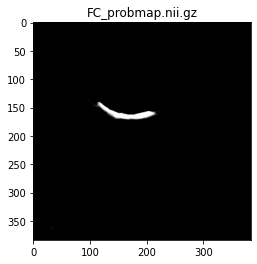

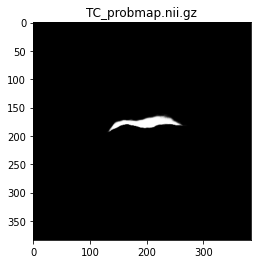

segmented
results/NotebookJune10/9279291/MR_SAG_3D_DESS/LEFT_KNEE/ENROLLMENT/avsm/FC_mesh_world.ply and results/NotebookJune10/9279291/MR_SAG_3D_DESS/LEFT_KNEE/ENROLLMENT/avsm/TC_mesh_world.ply exits


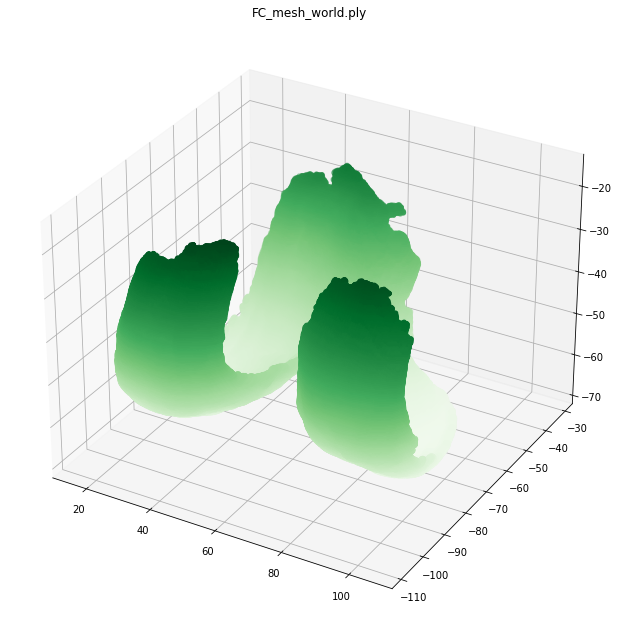

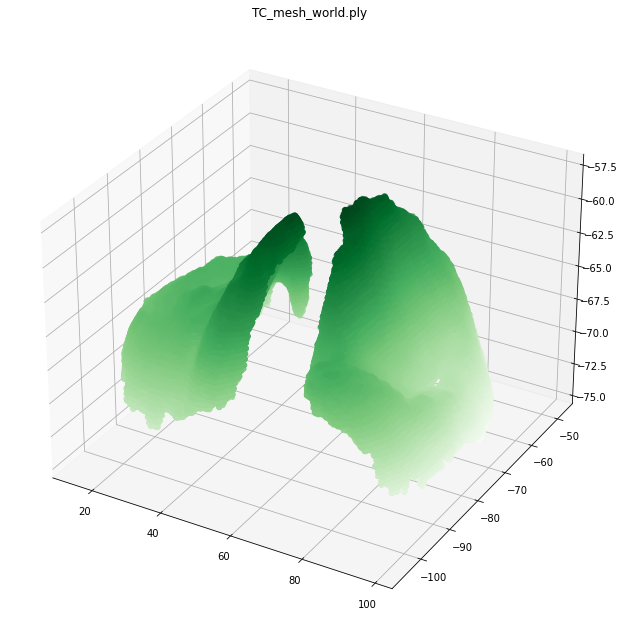

[NiftyReg] The specified transformation is a deformation field:
[NiftyReg] results/NotebookJune10/9279291/MR_SAG_3D_DESS/LEFT_KNEE/ENROLLMENT/avsm/inv_transform_to_atlas.nii.gz
[NiftyReg] The specified transformation is a deformation field:
[NiftyReg] results/NotebookJune10/9279291/MR_SAG_3D_DESS/LEFT_KNEE/ENROLLMENT/avsm/inv_transform_to_atlas.nii.gz
(348,)
(12,)


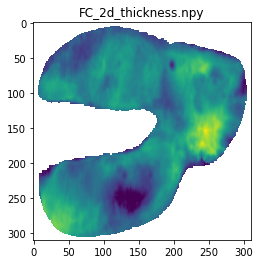

9279291_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS distance eval(mm):
FC distance: max:7.9813, min:0.0000, median:1.2554, 95 percent 3.7856
TC distance: max:4.2871, min:0.0000, median:0.8874, 95 percent 2.7845
FC distance(mm): max:7.9813 +/- 0.0000, min:0.0000 +/- 0.0000, median:1.2554 +/- 0.0000, 95 percent 3.7856408808768776 +/- 0.0
TC distance(mm): max:4.2871 +/- 0.0000, min:0.0000 +/- 0.0000, median:0.8874 +/- 0.0000, 95 percent 2.784491272436446 +/- 0.0


In [15]:
PARAMS["avsm_directory"] = "dependencies/easyreg"
OAI_data_sheet = PARAMS['oai_data_sheet']
OAI_data = OAIData(OAI_data_sheet, PARAMS['oai_data_directory'])
OAI_data.set_processed_data_paths( PARAMS['output_directory'], 'avsm')
print("made a bunch of folders")
test_image = OAI_data.get_images(patient_id= [9279291])[0] # 9279291, 9298954,9003380
analyzer = build_default_analyzer(use_nifty=True, avsm_path=PARAMS["avsm_directory"])
analyzer.preprocess(test_image, overwrite=False)
print("preprocessed")
analyzer.segment_image_and_save_results(test_image, overwrite=False)
analyzer.close_segmenter()
show_filename(test_image.FC_probmap_file)
show_filename(test_image.TC_probmap_file)
print("segmented")
analyzer.extract_surface_mesh(test_image, overwrite=False)
show_filename(test_image.FC_mesh_file)
show_filename(test_image.TC_mesh_file)
#analyzer.register_image_to_atlas(test_image, True)
analyzer.warp_mesh(test_image, overwrite=True,do_clean=True)
analyzer.project_thickness_to_atlas(test_image, overwrite=False)
analyzer.set_atlas_2D_map(PARAMS['atlas_fc_2d_map_path'], PARAMS['atlas_tc_2d_map_path'])
analyzer.compute_atlas_2D_map(n_jobs=None)
analyzer.project_thickness_to_2D(test_image, overwrite=False)
show_filename(test_image.FC_2D_thickness_grid)
analyzer.eval_registration_surface_distance(test_image)
analyzer.get_surface_distances_eval()



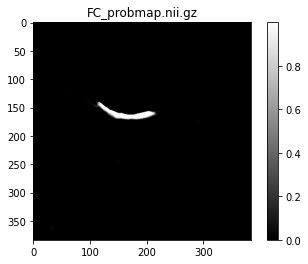

In [17]:
show_filename(test_image.FC_probmap_file)


In [23]:
OAI_data.get_images(patient_id= [9279291])

[9279291_ENROLLMENT_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_12_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_24_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_36_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_48_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_72_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_96_MONTH_LEFT_KNEE_MR_SAG_3D_DESS,
 9279291_ENROLLMENT_RIGHT_KNEE_MR_SAG_3D_DESS,
 9279291_12_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS,
 9279291_24_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS,
 9279291_36_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS,
 9279291_48_MONTH_RIGHT_KNEE_MR_SAG_3D_DESS]